In [1]:
import tifffile
import cv2
import numpy as np
import torch.nn.functional as F
import torch
import os
import random
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage.interpolation import zoom

from sr_3dunet.utils.data_utils import random_crop_3d, random_crop_2d, augment_3d, augment_2d, preprocess, get_projection, get_rotated_img, crop_block

/tmp/ipykernel_3465446/1421635885.py:12: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import zoom


In [ ]:
def extend_block_utils(img, step_size=16, dim=3):
    def extend_block_(img):
        if dim==3:
            h, w, d = img.shape
            pad_height = (step_size - h % step_size) if h % step_size != 0 else 0
            pad_width = (step_size - w % step_size) if w % step_size != 0 else 0
            pad_depth = (step_size - d % step_size) if d % step_size != 0 else 0
            
            padded_img = np.pad(img, ((0, pad_height), (0, pad_width), (0, pad_depth)), mode='constant') if isinstance(img, np.ndarray)\
                else F.pad(img, (0, pad_depth, 0, pad_width, 0, pad_height), mode='constant') 
        elif dim==2:
            h, w = img.shape
            pad_height = (step_size - h % step_size) if h % step_size != 0 else 0
            pad_width = (step_size - w % step_size) if w % step_size != 0 else 0
            
            padded_img = np.pad(img, ((0, pad_height), (0, pad_width)), mode='constant') if isinstance(img, np.ndarray)\
                else F.pad(img, (0, pad_width, 0, pad_height), mode='constant')
        return padded_img
                
    if img.ndim > 3:
        return extend_block_(img[0,0])[None, None]
    else:
        return extend_block_(img)
    
def get_rotated_img(raw_img, device, aniso_dimension=-2):
    raw_img = raw_img.astype(np.float32)
    list_img = []
    for i in range(raw_img.shape[aniso_dimension]):
        img = raw_img[..., i, :]
        height, width = img.shape
        max_size = max(height, width)

        desired_height = int(max_size * 1.414213) // 2 * 2
        desired_width = int(max_size * 1.414213) // 2 * 2

        border_height = (desired_height - height) // 2
        border_width = (desired_width - width) // 2

        center_x = desired_height // 2
        center_y = desired_height // 2
        rotation_matrix = cv2.getRotationMatrix2D((center_x, center_y), 45, 1)

        extend_img = np.pad(img, ((border_height, border_height), (border_width, border_width)), mode='constant')
        rotated_img = cv2.warpAffine(extend_img, rotation_matrix, (desired_width, desired_height))
        list_img.append(rotated_img)
    
    return extend_block_utils(np.stack(list_img, axis=1))

def get_projection(img, aniso_dimension=-2):
    list_dimensions = [-1, -2, -3]
    list_dimensions.remove(aniso_dimension)
    if isinstance(img, np.ndarray):
        img_aniso = np.max(img, axis=aniso_dimension)
        img_iso0 = np.max(img, axis=list_dimensions[0])
        img_iso1 = np.max(img, axis=list_dimensions[1])
    elif isinstance(img, torch.Tensor):
        img_aniso = torch.max(img, dim=aniso_dimension).values
        img_iso0 = torch.max(img, dim=list_dimensions[0]).values
        img_iso1 = torch.max(img, dim=list_dimensions[1]).values
    return img_aniso, img_iso0, img_iso1

绘制poster

In [ ]:
ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/CJ4ROI1.ims'
h5 = h5py.File(ims_path, 'r')
img_total_input = h5['DataSet']['ResolutionLevel 0']['TimePoint 0']['Channel 0']['Data']

ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/cellbody/new_out_h5/output_res0.h5'
h5 = h5py.File(ims_path, 'r')
img_total_output = h5['DataSet']['ResolutionLevel 0']['TimePoint 0']['Channel 0']['Data']

In [ ]:
print(img_total_input.shape)
print(img_total_output.shape)

len = 200

img_input = img_total_input[0:800, 4000:4000+len, 4000:4800]
img_output = img_total_output[0:800, 4000:4000+len, 4000:4800]

In [9]:
print(img_input.shape)
print(img_output.shape)

(800, 200, 800)
(800, 200, 800)


In [12]:
img_input_MIP, _, _ = get_projection(img_input)
img_output_MIP, _, _ = get_projection(img_output)

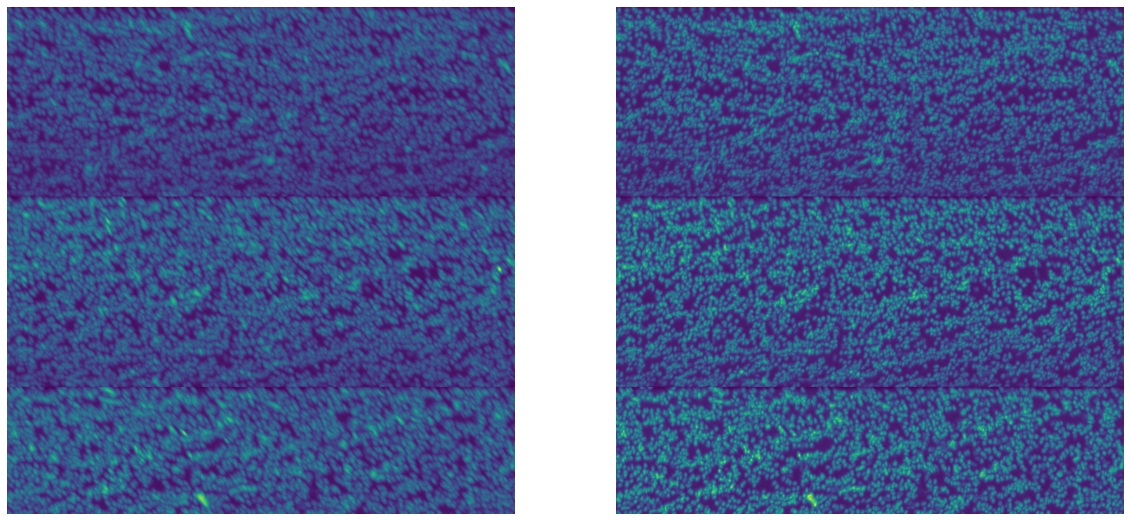

In [13]:
plt.figure(figsize=(20, 10))  # 设置图形的大小


plt.subplot(121)
plt.axis('off')
plt.imshow(img_input_MIP)
# plt.title('Original Image, level0, coor 0:800, 4000, 4000:4800')

plt.subplot(122)
plt.axis('off')
plt.imshow(img_output_MIP)
# plt.title('Processed Image, level0, coor 0:800, 4000, 4000:4800')

绘制poster NISSL

In [15]:
ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/CJ4ROI1.ims'
h5 = h5py.File(ims_path, 'r')
img_total_input = h5['DataSet']['ResolutionLevel 0']['TimePoint 0']['Channel 1']['Data']

ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/NISSL/out_h5/output_res0.h5'
h5 = h5py.File(ims_path, 'r')
img_total_output = h5['DataSet']['ResolutionLevel 0']['TimePoint 0']['Channel 1']['Data']

In [23]:
print(img_total_input.shape)
print(img_total_output.shape)

depth = 200

img_input = img_total_input[300:600, 4000:4000+depth, 3000:5500]
img_output = img_total_output[300:600, 4000:4000+depth, 3000:5500]

(928, 8448, 8704)
(928, 8448, 8704)


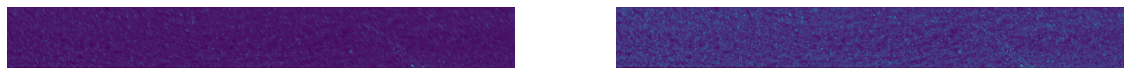

In [24]:
img_input_MIP, _, _ = get_projection(img_input)
img_output_MIP, _, _ = get_projection(img_output)

plt.figure(figsize=(20, 10))  # 设置图形的大小


plt.subplot(121)
plt.axis('off')
plt.imshow(img_input_MIP)
# plt.title('Original Image, level0, coor 0:800, 4000, 4000:4800')

plt.subplot(122)
plt.axis('off')
plt.imshow(img_output_MIP)
# plt.title('Processed Image, level0, coor 0:800, 4000, 4000:4800')

In [25]:
tifffile.imwrite('img_input_MIP.tif', img_input_MIP)
tifffile.imwrite('img_output_MIP.tif', img_output_MIP)

In [28]:
img_input_MIP

(300, 2500)

In [53]:
# len1 = 500
# len2 = 50
# start1 = 740
# start2 = 30

len1 = 500
len2 = 50
start1 = 800
start2 = 55

sub_img_input_MIP = img_input_MIP[start2:start2+len2, start1:start1+len1]
sub_img_output_MIP = img_output_MIP[start2:start2+len2, start1:start1+len1]

tifffile.imwrite('sub_img_input_MIP.tif', sub_img_input_MIP)
tifffile.imwrite('sub_img_output_MIP.tif', sub_img_output_MIP)

import imageio
imageio.imwrite('sub_img_input_MIP.png', sub_img_input_MIP)
imageio.imwrite('sub_img_output_MIP.png', sub_img_output_MIP)

In [54]:
import numpy as np
from PIL import Image

red_channel = sub_img_input_MIP

# 创建一个新的PIL图像，只包含红色通道
new_image = Image.fromarray(red_channel.astype('uint8'), 'L')

# 将单通道图像转换为三通道图像，以适应PNG格式
new_image = new_image.convert("RGB")

# 保存图像到PNG格式
new_image.save("red_channel_image.png", "PNG")

分解

In [ ]:
ims_path = '/share/data/VISoR_Reconstruction/SIAT_ION/LiuCiRong/20230910_CJ004/CJ4-1um-ROI1/CJ4ROI1.ims'

h5 = h5py.File(ims_path, 'r')
img_total_origin = h5['DataSet']['ResolutionLevel 0']['TimePoint 0']['Channel 1']['Data']

ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/NISSL/out_h5/output_res0.h5'

h5 = h5py.File(ims_path, 'r')
img_total_out = h5['DataSet']['ResolutionLevel 0']['TimePoint 0']['Channel 1']['Data']

In [ ]:
img_ori = img_total_origin[:,3500:4000, 4000:4928]
img_out = img_total_out[:,3500:4000, 4000:4928]

In [ ]:
rotated_img_ori = get_rotated_img(img_ori, None)
rotated_img_out = get_rotated_img(img_out, None)

In [ ]:
rotated_img_ori = get_rotated_img(img_ori, None)
# rotated_img_ori = rotated_img_ori[rotated_img_ori.shape[0]//2-2:rotated_img_ori.shape[0]//2*3+2, :, rotated_img_ori.shape[2]//2-2:rotated_img_ori.shape[2]//2*3+2]
rotated_img_ori.shape

In [ ]:
tifffile.imwrite('rotated_img_ori.tif', rotated_img_ori)

In [ ]:
tifffile.imwrite('cube_origin_dim1.tif', img_total_origin[:,3500:4000, 4000:5000])
tifffile.imwrite('cube_out_dim1.tif', img_total_out[:,3500:4000, 4000:5000])

In [ ]:
img_total_origin.shape

ROI2

In [ ]:
plt.figure(figsize=(20, 10))  # 设置图形的大小
ims_path = '/share/data/VISoR_Reconstruction/SIAT_ION/LiuCiRong/20230910_CJ004/CJ4-1um-ROI1/CJ4ROI2.ims'

h5 = h5py.File(ims_path, 'r')
img_total = h5['DataSet']['ResolutionLevel 0']['TimePoint 0']['Channel 0']['Data']
print(img_total.shape)

plt.subplot(121)
plt.axis('off')
plt.imshow(img_total[0:800, 2000, 4000:4800])
plt.title('Original Image, level0, coor 0:800, 2000, 4000:4800')

ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/NISSL/CJ4ROI2_out_h5/output_res0.h5'
h5 = h5py.File(ims_path, 'r')
img_total = h5['DataSet']['ResolutionLevel 0']['TimePoint 0']['Channel 0']['Data']
print(img_total.shape)

plt.subplot(122)
plt.axis('off')
plt.imshow(img_total[0:800, 2000, 4000:4800])
plt.title('Processed Image, level0, coor 0:800, 2000, 4000:4800')

In [ ]:
plt.figure(figsize=(20, 10))  # 设置图形的大小
ims_path = '/share/data/VISoR_Reconstruction/SIAT_ION/LiuCiRong/20230910_CJ004/CJ4-1um-ROI1/CJ4ROI2.ims'

h5 = h5py.File(ims_path, 'r')
img_total = h5['DataSet']['ResolutionLevel 1']['TimePoint 0']['Channel 0']['Data']
print(img_total.shape)

plt.subplot(121)
plt.axis('off')
plt.imshow(img_total[0:400, 1000, 2000:2400])
plt.title('Original Image, level1, coor 0:400, 2000, 2000:2400')

ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/NISSL/CJ4ROI2_out_h5/output_res1.h5'
h5 = h5py.File(ims_path, 'r')
img_total = h5['DataSet']['ResolutionLevel 1']['TimePoint 0']['Channel 0']['Data']
print(img_total.shape)

plt.subplot(122)
plt.axis('off')
plt.imshow(img_total[0:400, 1000, 2000:2400])
plt.title('Processed Image, level1, coor 0:400, 2000, 2000:2400')

In [ ]:
plt.figure(figsize=(20, 10))  # 设置图形的大小
ims_path = '/share/data/VISoR_Reconstruction/SIAT_ION/LiuCiRong/20230910_CJ004/CJ4-1um-ROI1/CJ4ROI2.ims'

h5 = h5py.File(ims_path, 'r')
img_total = h5['DataSet']['ResolutionLevel 2']['TimePoint 0']['Channel 0']['Data']
print(img_total.shape)

plt.subplot(121)
plt.axis('off')
plt.imshow(img_total[0:200, 500, 1000:1200])
plt.title('Original Image, level2, coor 0:200, 500, 1000:1200')

ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/NISSL/CJ4ROI2_out_h5/output_res2.h5'
h5 = h5py.File(ims_path, 'r')
img_total = h5['DataSet']['ResolutionLevel 2']['TimePoint 0']['Channel 0']['Data']
print(img_total.shape)

plt.subplot(122)
plt.axis('off')
plt.imshow(img_total[0:200, 500, 1000:1200])
plt.title('Processed Image, level2, coor 0:200, 500, 1000:1200')

level0 效果对比

In [ ]:
plt.figure(figsize=(20, 10))  # 设置图形的大小
ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/CJ4ROI1.ims'

h5 = h5py.File(ims_path, 'r')
img_total = h5['DataSet']['ResolutionLevel 0']['TimePoint 0']['Channel 0']['Data']
print(img_total.shape)

plt.subplot(121)
plt.axis('off')
plt.imshow(img_total[0:800, 4000, 4000:4800])
plt.title('Original Image, level0, coor 0:800, 4000, 4000:4800')

ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/cellbody/new_out_h5/output_res0.h5'
h5 = h5py.File(ims_path, 'r')
img_total = h5['DataSet']['ResolutionLevel 0']['TimePoint 0']['Channel 0']['Data']
print(img_total.shape)

plt.subplot(122)
plt.axis('off')
plt.imshow(img_total[0:800, 4000, 4000:4800])
plt.title('Processed Image, level0, coor 0:800, 4000, 4000:4800')

level1 效果对比

In [ ]:
plt.figure(figsize=(20, 10))  # 设置图形的大小
ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/CJ4ROI1.ims'

h5 = h5py.File(ims_path, 'r')
img_total = h5['DataSet']['ResolutionLevel 1']['TimePoint 0']['Channel 0']['Data']
print(img_total.shape)

plt.subplot(121)
plt.axis('off')
plt.imshow(img_total[0:400, 2000, 2000:2400])
plt.title('Original Image, level1, coor 0:400, 2000, 2000:2400')

ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/cellbody/new_out_h5/output_res1.h5'
h5 = h5py.File(ims_path, 'r')
img_total = h5['DataSet']['ResolutionLevel 1']['TimePoint 0']['Channel 0']['Data']
print(img_total.shape)

plt.subplot(122)
plt.axis('off')
plt.imshow(img_total[0:400, 2000, 2000:2400])
plt.title('Processed Image, level1, coor 0:400, 2000, 2000:2400')

level2 效果对比

In [ ]:
plt.figure(figsize=(20, 10))  # 设置图形的大小
ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/CJ4ROI1.ims'

h5 = h5py.File(ims_path, 'r')
img_total = h5['DataSet']['ResolutionLevel 2']['TimePoint 0']['Channel 0']['Data']
print(img_total.shape)

plt.subplot(121)
plt.axis('off')
plt.imshow(img_total[0:200, 1000, 1000:1200])
plt.title('Original Image, level2, coor 0:200, 1000, 1000:1200')

ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/cellbody/new_out_h5/output_res2.h5'
h5 = h5py.File(ims_path, 'r')
img_total = h5['DataSet']['ResolutionLevel 2']['TimePoint 0']['Channel 0']['Data']
print(img_total.shape)

plt.subplot(122)
plt.axis('off')
plt.imshow(img_total[0:200, 1000, 1000:1200])
plt.title('Processed Image, level2, coor 0:200, 1000, 1000:1200')

new和old的对比效果

In [ ]:
plt.figure(figsize=(20, 10))  # 设置图形的大小
ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/cellbody/out_h5/output_res1.h5'
h5 = h5py.File(ims_path, 'r')
img_total = h5['DataSet']['ResolutionLevel 1']['TimePoint 0']['Channel 0']['Data']
print(img_total.shape)

plt.subplot(121)
plt.axis('off')
plt.imshow(img_total[0:400, 2000, 2000:2400])
plt.title('Processed Image, level1, coor 0:400, 2000, 2000:2400')

ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/cellbody/new_out_h5/output_res0.h5'
h5 = h5py.File(ims_path, 'r')
img_total = h5['DataSet']['ResolutionLevel 0']['TimePoint 0']['Channel 0']['Data']
print(img_total.shape)

plt.subplot(122)
plt.axis('off')
plt.imshow(img_total[0:800, 4000, 4000:4800])
plt.title('Processed Image_new, level0, coor 0:800, 4000, 4000:4800')

level0 效果对比

In [ ]:
plt.figure(figsize=(20, 10))  # 设置图形的大小
ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/CJ4ROI1.ims'

h5 = h5py.File(ims_path, 'r')
img_total = h5['DataSet']['ResolutionLevel 0']['TimePoint 0']['Channel 0']['Data']
print(img_total.shape)

plt.subplot(121)
plt.axis('off')
plt.imshow(img_total[0:800, 4000, 4000:4800])
plt.title('Original Image, level0, coor 0:800, 4000, 4000:4800')

ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/cellbody/out_h5/output_res0.h5'
h5 = h5py.File(ims_path, 'r')
img_total = h5['DataSet']['ResolutionLevel 0']['TimePoint 0']['Channel 0']['Data']
print(img_total.shape)

plt.subplot(122)
plt.axis('off')
plt.imshow(img_total[0:800, 4000, 4000:4800])
plt.title('Processed Image, level0, coor 0:800, 4000, 4000:4800')

level1 效果对比

In [ ]:
plt.figure(figsize=(20, 10))  # 设置图形的大小
ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/CJ4ROI1.ims'

h5 = h5py.File(ims_path, 'r')
img_total = h5['DataSet']['ResolutionLevel 1']['TimePoint 0']['Channel 0']['Data']
print(img_total.shape)

plt.subplot(121)
plt.axis('off')
plt.imshow(img_total[0:400, 2000, 2000:2400])
plt.title('Original Image, level1, coor 0:400, 2000, 2000:2400')

ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/cellbody/out_h5/output_res1.h5'
h5 = h5py.File(ims_path, 'r')
img_total = h5['DataSet']['ResolutionLevel 1']['TimePoint 0']['Channel 0']['Data']
print(img_total.shape)

plt.subplot(122)
plt.axis('off')
plt.imshow(img_total[0:400, 2000, 2000:2400])
plt.title('Processed Image, level1, coor 0:400, 2000, 2000:2400')

level2 效果对比

In [ ]:
plt.figure(figsize=(20, 10))  # 设置图形的大小
ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/CJ4ROI1.ims'

h5 = h5py.File(ims_path, 'r')
img_total = h5['DataSet']['ResolutionLevel 2']['TimePoint 0']['Channel 0']['Data']
print(img_total.shape)

plt.subplot(121)
plt.axis('off')
plt.imshow(img_total[0:200, 1000, 1000:1200])
plt.title('Original Image, level2, coor 0:200, 1000, 1000:1200')

ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/cellbody/out_h5/output_res2.h5'
h5 = h5py.File(ims_path, 'r')
img_total = h5['DataSet']['ResolutionLevel 2']['TimePoint 0']['Channel 0']['Data']
print(img_total.shape)

plt.subplot(122)
plt.axis('off')
plt.imshow(img_total[0:200, 1000, 1000:1200])
plt.title('Processed Image, level2, coor 0:200, 1000, 1000:1200')

打印目录

In [ ]:
import h5py

def print_h5_structure(h5_obj, level=0):
    for key in h5_obj.keys():
        print("  " * level + f"- {key}")
        if isinstance(h5_obj[key], h5py.Group):
            print_h5_structure(h5_obj[key], level + 1)

# 打开 h5 文件
h5_file = h5py.File('/share/data/VISoR_Reconstruction/SIAT_ION/LiuCiRong/20230910_CJ004/CJ4-1um-ROI1/CJ4ROI2.ims', 'r')

# 打印 h5 文件的目录结构
print("HDF5 file structure:")
print_h5_structure(h5_file)
print('size:', h5_file['DataSet']['ResolutionLevel 0']['TimePoint 0']['Channel 0']['Data'].shape)

# 关闭 h5 文件
h5_file.close()

In [ ]:
import h5py

def print_h5_structure(h5_obj, level=0):
    for key in h5_obj.keys():
        print("  " * level + f"- {key}")
        if isinstance(h5_obj[key], h5py.Group):
            print_h5_structure(h5_obj[key], level + 1)

# 打开 h5 文件
h5_file = h5py.File('/share/data/VISoR_Reconstruction/SIAT_ION/LiuCiRong/20230910_CJ004/CJ4-1um-ROI1/CJ4ROI1.ims', 'r')

# 打印 h5 文件的目录结构
print("HDF5 file structure:")
print_h5_structure(h5_file)
print('size:', h5_file['DataSet']['ResolutionLevel 0']['TimePoint 0']['Channel 0']['Data'].shape)

# 关闭 h5 文件
h5_file.close()

阈值设置为1000？

In [ ]:
len = 128

tifffile.imsave('total.tif', img_total[200:200+len, 3000:3000+len, 3000:3000+len])

In [2]:
img = tifffile.imread('/share/home/wangwb/workspace/sr_3dunet/datasets/40X/40x20x03px0p26ax.tif')

img.shape

(3656, 555, 2937)

In [3]:
img = img.transpose(0,2,1)
img.shape

(3656, 2937, 555)

In [5]:
size = 200
startx = 2112
starty = 1029
startz = 175

tifffile.imwrite('tmp.tif', img[startx:startx+size*2, starty:starty+size, startz:startz+size])

simulation数据unpaired 超分辨

In [11]:
input_img_folder = '/share/home/wangwb/workspace/sr_3dunet/datasets/simulation/blurred_split_noised'
output_img_folder = '/share/home/wangwb/workspace/sr_3dunet/datasets/simulation/blurred_split_noised_downsample_x'

downsample_scale = 2
output_img_folder += str(downsample_scale)

if not os.path.exists(output_img_folder):
    os.makedirs(output_img_folder, exist_ok=True)

img_list = os.listdir(input_img_folder)

for img_name in img_list:
    input_img_path = os.path.join(input_img_folder, img_name)
    output_img_path = os.path.join(output_img_folder, img_name)
    img = tifffile.imread(input_img_path)
    # img = cv2.resize(img, None, fx=1/downsample_scale, fy=1/downsample_scale, interpolation=cv2.INTER_CUBIC)
    # img = img.transpose(2,1,0)
    # img = cv2.resize(img, None, fx=1, fy=1/downsample_scale, interpolation=cv2.INTER_CUBIC)
    # img = img.transpose(2,1,0)
    img = zoom(img, zoom = 1/downsample_scale, order=3)
    tifffile.imwrite(output_img_path, img)
    